In [ ]:
# Importing the libraries

In [25]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
import re
from itertools import islice
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download("stopwords")
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer
import matplotlib.pyplot as plt
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddhanthkalyanpur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Importing the dataset

In [3]:
with open("train.dat", "r", encoding = "utf-8") as train_reader:
    train_data = train_reader.readlines()
    
with open("test.dat", "r", encoding = "utf-8") as test_reader:
    test_data = test_reader.readlines()

In [139]:
# len(test_data)

15000

In [114]:
# Splitting the dataset

In [34]:
train_sentiments = [data.split("\t", 1)[0] for data in train_data]
train_reviews = [data.split("\t", 1)[1] for data in train_data]

# print("Count of Train Sentiments: ", len(train_sentiments))
# print("Count of Train Reviews: ", len(train_reviews))
# print(train_reviews[4])
# print("Count of Test Reviews: ", len(test_data))

In [35]:
# Remove Noise

In [115]:
def remove_noise(review):
    beautifulSoup = BeautifulSoup(review, "html.parser")
    review =  beautifulSoup.get_text()
    review = re.sub("\[[^]]*\]", "", review)
    review = re.sub(r"[^a-zA-z0-9\s]", "", review)
    return review

In [37]:
# Remove Noise from Review column of both Train and Test data

In [116]:
train_reviews = list(map(remove_noise, train_reviews))
test_review = list(map(remove_noise, test_data))

In [117]:
# Data Preprocessing 

In [118]:
def pre_Process_Data(review):
    review_tokens = ToktokTokenizer().tokenize(review)
    review_tokens = [token.strip() for token in review_tokens]
    clean_tokens = [token for token in review_tokens if token.lower() not in stopwords.words("english")]
    review = " ".join(clean_tokens) 
    review = " ".join([LancasterStemmer().stem(word) for word in review.split()])
    return review

In [119]:
preprocessed_train_reviews = list(map(pre_Process_Data, train_reviews))
preprocessed_test_reviews = list(map(pre_Process_Data, test_review))
preprocessed_train_reviews

['germ filmmak ull lommel man task many hor fan thought imposs hes uns fellow teuton uw bol crown direct worst hor film ev madelommel tru ed wood new millenn film shoddy laugh bestworst ew proud embarrass say watch toto morbid fascin see low bar could set answ subter lommel dug pit bury itth fun begin cast intern nobody someon liv los angel every auto mech doct mailm act screenwriter wait discov could easy understand lommel man find many wannab act wil spew ridic dialog straight faceth main charact villain beat cop play germ act thick germ acc asid ser kil also oldest beat cop la despit fact stop innoc wom driv tak custody drag hom inexpl top flo furnit wareh plain sight rooky partn lapd refus investig going far phys attack on accus ninj styl raid apartmentth set excrucy bad produc design budget app includ enough money paint enough paint precinct 707 cardboard wallsint act obvy unpaid nonprofessionals sad assort europ emigr poss deport act nat land bimbo mimbo desp middl womenand sint 

In [97]:
# preprocessed_train_reviews = pd.DataFrame(preprocessed_train_reviews)
# preprocessed_test_reviews = pd.DataFrame(preprocessed_test_reviews)
# preprocessed_train_reviews.head()

In [98]:
count_vector = CountVectorizer(min_df=.01, max_df=0.75, ngram_range=(1,3))
count_vector.fit(preprocessed_train_reviews)
list(islice(count_vector.vocabulary_.items(), 20))

[('germ', 636),
 ('filmmak', 568),
 ('man', 920),
 ('many', 921),
 ('hor', 730),
 ('fan', 525),
 ('thought', 1519),
 ('imposs', 762),
 ('hes', 711),
 ('fellow', 543),
 ('direct', 391),
 ('worst', 1676),
 ('film', 554),
 ('ev', 482),
 ('tru', 1563),
 ('wood', 1668),
 ('new', 1024),
 ('laugh', 850),
 ('embarrass', 451),
 ('say', 1299)]

In [99]:
cvec_counts = count_vector.transform(preprocessed_train_reviews)
test_vector = count_vector.transform(preprocessed_test_reviews)

In [100]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
test_weights = transformer.fit_transform(test_vector)

# transformed_weights

<15000x1707 sparse matrix of type '<class 'numpy.float64'>'
	with 1097620 stored elements in Compressed Sparse Row format>

In [120]:
def cosine_Similarities(train_vector_matrix, test_vector_matrix):
    transposed_train_vector = np.transpose(train_vector_matrix)
    cosine_similarities_reviews = np.dot(test_vector_matrix, transposed_train_vector)
    return cosine_similarities_reviews.toarray()        

def kNearestNeighbours(review_similarity, k):
    return np.argsort(-review_similarity)[:k]    

def predict_Sentiment(k_nearest_neighbours, sentiments):
    positive_sentiment, negative_sentiment = 0, 0
    for nearest_neighbour in k_nearest_neighbours:
        if int(sentiments[nearest_neighbour]) == 1:
            positive_sentiment += 1
        else:
            negative_sentiment += 1
    return "+1" if (positive_sentiment >= negative_sentiment) else "-1"

In [121]:
review_similarities = cosine_Similarities(transformed_weights, test_weights)

In [153]:
k = 414 

test_sentiments = []

for review_similarity in review_similarities:
    kNN = kNearestNeighbours(review_similarity, k)
    prediction = predict_Sentiment(kNN, train_sentiments)
    test_sentiments.append(prediction)

In [154]:
sentiment_file = open("format.dat", "w")
sentiment_file.writelines("%s\n" % sentiment for sentiment in test_sentiments)
sentiment_file.close()

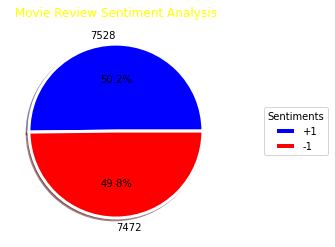

In [155]:
sentiments = Counter(test_sentiments).keys()
sentiments_count = Counter(test_sentiments).values()
plt.pie(sentiments_count, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' } , labels = sentiments_count, shadow = True, autopct = "%1.1f%%", colors = ['blue', 'red'])
plt.legend(sentiments, title = "Sentiments", loc = "center right", bbox_to_anchor = (1, 0, 0.5, 1))
plt.title("Movie Review Sentiment Analysis" , color = 'yellow')
plt.show()